### STEP 1: IMPORT LIBRARIES

In [76]:
import os
import re
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, roc_auc_score, average_precision_score
import krippendorff 
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

### STEP 2: SET PATH FOR DATASET

In [77]:
dataset_path = r"D:\FAST\Semester 8\Deep Learning\DL_Assignment1_Dataset\Dataset\Dataset" 
images_folder = os.path.join(dataset_path, "images")
annotations_folder = os.path.join(dataset_path, "annotations")

### STEP 3: INSPECTING FILES BEFORE CONCATENATION

In [78]:
print("Files in annotation folder:")
for f in os.listdir(annotations_folder):
    print(f)


Files in annotation folder:
0_aro.npy
0_exp.npy
0_lnd.npy
0_val.npy
1001_aro.npy
1001_exp.npy
1001_lnd.npy
1001_val.npy
1002_aro.npy
1002_exp.npy
1002_lnd.npy
1002_val.npy
1003_aro.npy
1003_exp.npy
1003_lnd.npy
1003_val.npy
1007_aro.npy
1007_exp.npy
1007_lnd.npy
1007_val.npy
1008_aro.npy
1008_exp.npy
1008_lnd.npy
1008_val.npy
1009_aro.npy
1009_exp.npy
1009_lnd.npy
1009_val.npy
100_aro.npy
100_exp.npy
100_lnd.npy
100_val.npy
1010_aro.npy
1010_exp.npy
1010_lnd.npy
1010_val.npy
1011_aro.npy
1011_exp.npy
1011_lnd.npy
1011_val.npy
1012_aro.npy
1012_exp.npy
1012_lnd.npy
1012_val.npy
1013_aro.npy
1013_exp.npy
1013_lnd.npy
1013_val.npy
1014_aro.npy
1014_exp.npy
1014_lnd.npy
1014_val.npy
1016_aro.npy
1016_exp.npy
1016_lnd.npy
1016_val.npy
1017_aro.npy
1017_exp.npy
1017_lnd.npy
1017_val.npy
1018_aro.npy
1018_exp.npy
1018_lnd.npy
1018_val.npy
1019_aro.npy
1019_exp.npy
1019_lnd.npy
1019_val.npy
101_aro.npy
101_exp.npy
101_lnd.npy
101_val.npy
1020_aro.npy
1020_exp.npy
1020_lnd.npy
1020_val.npy
1021

In [79]:
for fname in sorted(os.listdir(annotations_folder)):
    fpath = os.path.join(annotations_folder, fname)
    try:
        arr = np.load(fpath, allow_pickle=True)
        if isinstance(arr, np.ndarray):
            print(f"{fname:<15} -> ndarray, shape: {arr.shape}, dtype: {arr.dtype}")
        else:
            print(f"{fname:<15} -> Not ndarray, type: {type(arr)}")
    except Exception as e:
        print(f"{fname:<15} -> Error loading file: {e}")


0_aro.npy       -> ndarray, shape: (), dtype: <U10
0_exp.npy       -> ndarray, shape: (), dtype: <U1
0_lnd.npy       -> ndarray, shape: (136,), dtype: float64
0_val.npy       -> ndarray, shape: (), dtype: <U9
1001_aro.npy    -> ndarray, shape: (), dtype: <U10
1001_exp.npy    -> ndarray, shape: (), dtype: <U1
1001_lnd.npy    -> ndarray, shape: (136,), dtype: float64
1001_val.npy    -> ndarray, shape: (), dtype: <U9
1002_aro.npy    -> ndarray, shape: (), dtype: <U8
1002_exp.npy    -> ndarray, shape: (), dtype: <U1
1002_lnd.npy    -> ndarray, shape: (136,), dtype: float64
1002_val.npy    -> ndarray, shape: (), dtype: <U8
1003_aro.npy    -> ndarray, shape: (), dtype: <U8
1003_exp.npy    -> ndarray, shape: (), dtype: <U1
1003_lnd.npy    -> ndarray, shape: (136,), dtype: float64
1003_val.npy    -> ndarray, shape: (), dtype: <U9
1007_aro.npy    -> ndarray, shape: (), dtype: <U9
1007_exp.npy    -> ndarray, shape: (), dtype: <U1
1007_lnd.npy    -> ndarray, shape: (136,), dtype: float64
1007_val

### STEP 4: LOAD & MERGE IMAGES & ANNOTATION FILES

In [80]:
# Natural sort for matching order

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

# Collect image indices based on annotation files
exp_files = sorted([f for f in os.listdir(annotations_folder) if f.endswith("_exp.npy")], key=natural_sort_key)

expressions, valence, arousal, images = [], [], [], []

for exp_file in exp_files:
    # Get base name (e.g., "0" from "0_exp.npy")
    base = exp_file.split("_")[0]

    # Build paths
    exp_path = os.path.join(annotations_folder, f"{base}_exp.npy")
    val_path = os.path.join(annotations_folder, f"{base}_val.npy")
    aro_path = os.path.join(annotations_folder, f"{base}_aro.npy")
    img_path = os.path.join(images_folder, f"{base}.jpg")

    # Load annotations (convert from string to numeric)
    exp_value = np.load(exp_path, allow_pickle=True).item()  # scalar string
    val_value = np.load(val_path, allow_pickle=True).item()
    aro_value = np.load(aro_path, allow_pickle=True).item()

    expressions.append(int(exp_value))       # convert to int
    valence.append(float(val_value))         # convert to float
    arousal.append(float(aro_value))         # convert to float

    # Load image
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        images.append(img_array)

expressions = np.array(expressions)
valence = np.array(valence)
arousal = np.array(arousal)
images = np.array(images) / 255.0  # normalize

print(f"✅ Loaded -> Images: {images.shape}, Expressions: {expressions.shape}, Valence: {valence.shape}, Arousal: {arousal.shape}")



✅ Loaded -> Images: (3999, 224, 224, 3), Expressions: (3999,), Valence: (3999,), Arousal: (3999,)


### STEP 5:  Sanity check: displaying one example

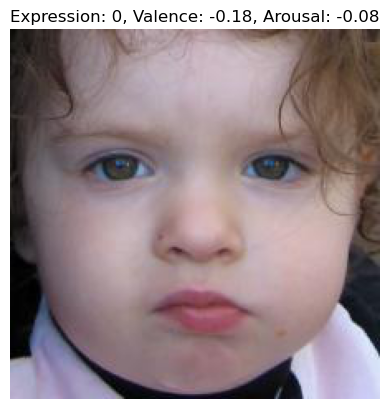

In [81]:
plt.imshow(images[0])
plt.title(f"Expression: {expressions[0]}, Valence: {valence[0]:.2f}, Arousal: {arousal[0]:.2f}")
plt.axis("off")
plt.show()


In [82]:
print("Unique expression labels:", np.unique(expressions))

Unique expression labels: [0 1 2 3 4 5 6 7]


In [83]:
class_names = ["Neutral", "Happy", "Sad", "Surprise", "Fear", "Disgust", "Angry", "Contempt"]

### Step 6: Train/Validation/Test Split + One-Hot Encoding

In [84]:
# Split: 70% train, 20% val, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(images, expressions, test_size=0.3, random_state=42, stratify=expressions)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)

# One-hot encode labels for classification
y_train_cat = to_categorical(y_train, num_classes=8)
y_val_cat = to_categorical(y_val, num_classes=8)
y_test_cat = to_categorical(y_test, num_classes=8)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (2799, 224, 224, 3), Val: (804, 224, 224, 3), Test: (396, 224, 224, 3)


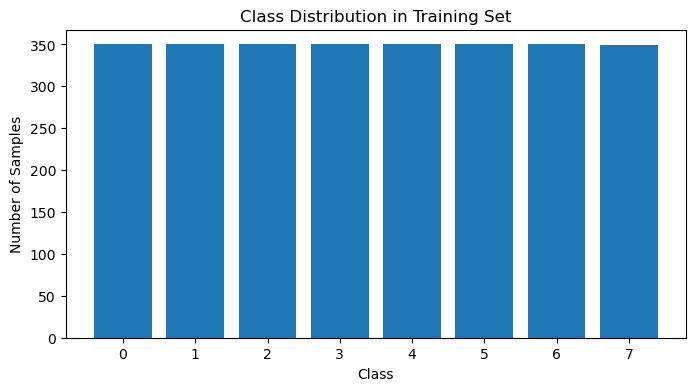

Class 0: 350 samples
Class 1: 350 samples
Class 2: 350 samples
Class 3: 350 samples
Class 4: 350 samples
Class 5: 350 samples
Class 6: 350 samples
Class 7: 349 samples


In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Count samples per class
unique, counts = np.unique(y_train, return_counts=True)

# Plot class distribution
plt.figure(figsize=(8,4))
plt.bar(unique, counts)
plt.xticks(unique)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Set")
plt.show()

# Print class counts for reference
for cls, cnt in zip(unique, counts):
    print(f"Class {cls}: {cnt} samples")


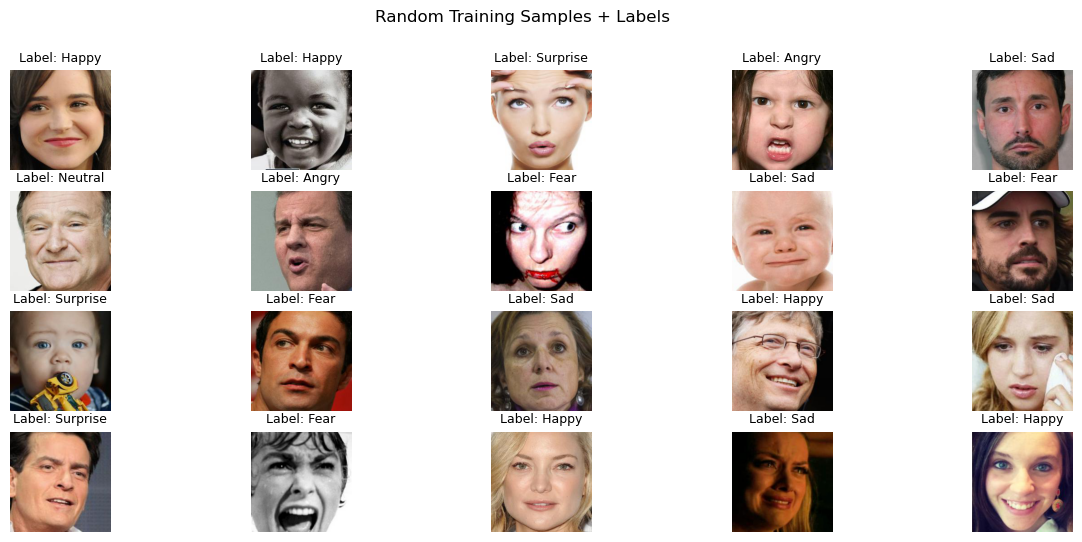

In [86]:
import random
sample_idx = random.sample(range(len(X_train)), 20)

plt.figure(figsize=(15,6))
for i, idx in enumerate(sample_idx):
    plt.subplot(4,5,i+1)
    plt.imshow(X_train[idx])
    plt.title(f"Label: {class_names[y_train[idx]]}", fontsize=9)
    plt.axis("off")
plt.suptitle("Random Training Samples + Labels")
plt.show()


### Step 7: Build a CNN EfficientNetV2B0

In [42]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# -----------------------------
# Load pretrained EfficientNetV2B0 (no top layer)
# -----------------------------
base_effnet = EfficientNetV2B0(
    weights='imagenet',       # Use pretrained ImageNet weights
    include_top=False,        # Exclude default classification head
    input_shape=(224, 224, 3)
)

# Freeze the base model
for layer in base_effnet.layers:
    layer.trainable = False

# -----------------------------
# Add custom classification head
# -----------------------------
x = GlobalAveragePooling2D()(base_effnet.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(8, activation='softmax')(x)  # 8 classes

# -----------------------------
# Create final model
# -----------------------------
model_effnet = Model(inputs=base_effnet.input, outputs=output)

# Compile the model
model_effnet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model_effnet.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,249,304 (23.84 MB)

 Trainable params: 329,992 (1.26 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

### Step 8: Train EFFICIENT-NET

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
from tensorflow.keras.optimizers import Adam

# -----------------------------
# Define Callbacks
# -----------------------------
early_stop = EarlyStopping(
    monitor='val_loss',        # monitor validation loss
    patience=5,                # stop if no improvement for 5 epochs
    restore_best_weights=True  # restore best model weights
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # reduce LR by 50%
    patience=3,       # if no improvement for 3 epochs, reduce LR
    min_lr=1e-6       # don't go below this LR
)


# 1. Unfreeze some or all layers of the base model
base_effnet.trainable = True

# 2. Compile model with a very low learning rate
model_effnet.compile(
    optimizer=Adam(learning_rate=1e-5),  # very low LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Train with same callbacks as before
start_time = time.time()

history_effnet_finetune = model_effnet.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=15,                
    batch_size=128,
    callbacks=[early_stop, lr_scheduler],  # reuse the callbacks
    verbose=1
)

finetune_train_time = time.time() - start_time
print(f" EfficientNetV2 Fine-Tuning Time: {finetune_train_time:.2f} seconds")



Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.1286 - loss: 2.0980 - val_accuracy: 0.1244 - val_loss: 2.0820 - learning_rate: 1.0000e-05
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.1250 - loss: 2.0883 - val_accuracy: 0.1244 - val_loss: 2.0798 - learning_rate: 1.0000e-05
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.1290 - loss: 2.0924 - val_accuracy: 0.1244 - val_loss: 2.0797 - learning_rate: 1.0000e-05
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.1297 - loss: 2.0901 - val_accuracy: 0.1269 - val_loss: 2.0796 - learning_rate: 1.0000e-05
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.1329 - loss: 2.0894 - val_accuracy: 0.1144 - val_loss: 2.0796 - learning_rate: 1.0000e-05
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.1293 - loss: 2.0906 - val_accuracy: 0.1206 - val_loss: 2.0795 - learning_rate: 1.0000e-05
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.1297 - loss:

### STEP 10: MODEL EVALUATION ON TEST SET

In [44]:
def evaluate_classification_model(y_true, y_pred, y_pred_probs, model_name):
    print(f"\nEvaluation for {model_name} MODEL")

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # F1-score (macro)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"F1-Score (Macro): {f1:.4f}")

    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Krippendorff's Alpha (requires reliability data as nominal)
    data = np.array([y_true, y_pred])
    alpha = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
    print(f"Krippendorff's Alpha: {alpha:.4f}")

    # AUC (One-vs-Rest)
    try:
        auc_ovr = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
        print(f"AUC-ROC (OvR): {auc_ovr:.4f}")
    except:
        print("Could not compute AUC-ROC (need probability outputs)")

    # Precision-Recall AUC
    try:
        auc_pr = average_precision_score(y_true, y_pred_probs, average="macro")
        print(f"Precision-Recall AUC-PR: {auc_pr:.4f}")
    except:
        print("Could not compute Precision-Recall AUC-PR (need probability outputs)")


In [45]:
# Predict probabilities using EfficientNetV2
y_pred_probs_effnet = model_effnet.predict(X_test)

# Get predicted class indices
y_pred_classes_effnet = np.argmax(y_pred_probs_effnet, axis=1)

# Evaluate model
evaluate_classification_model(y_test, y_pred_classes_effnet, y_pred_probs_effnet, "EfficientNetV2")


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 753ms/step

Evaluation for EfficientNetV2 MODEL
Accuracy: 0.1212
F1-Score (Macro): 0.0420
Cohen's Kappa: -0.0030
Krippendorff's Alpha: -0.2512
AUC-ROC (OvR): 0.5090
Precision-Recall AUC-PR: 0.1392


### STEP 9: ACCURACY & LOSS PLOTS

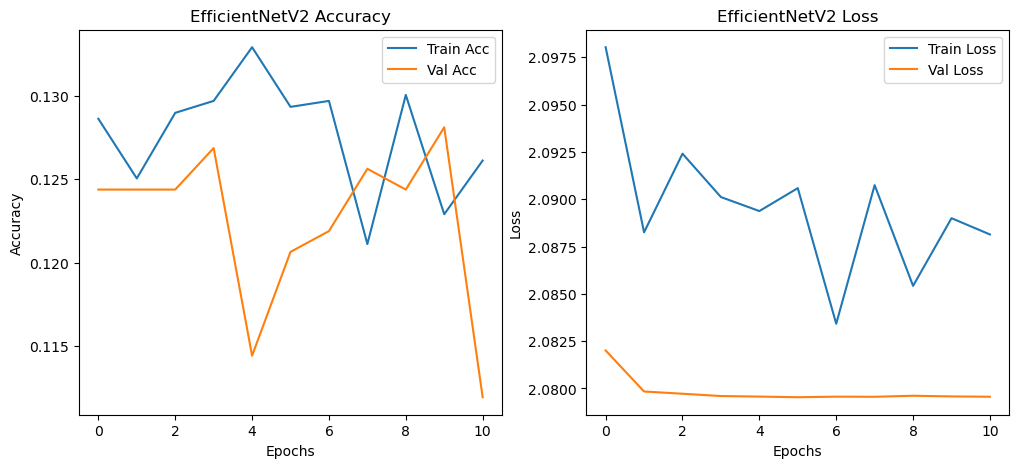

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_effnet_finetune.history['accuracy'], label='Train Acc')
plt.plot(history_effnet_finetune.history['val_accuracy'], label='Val Acc')
plt.title('EfficientNetV2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_effnet_finetune.history['loss'], label='Train Loss')
plt.plot(history_effnet_finetune.history['val_loss'], label='Val Loss')
plt.title('EfficientNetV2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Correct and Incorrect Classified Images for EfficientNetV2B0

In [47]:

y_pred_probs_effnet = model_effnet.predict(X_test)
y_pred_classes_effnet = np.argmax(y_pred_probs_effnet, axis=1)

# Find indices of correct and incorrect predictions
correct_idx_effnet = np.where(y_pred_classes_effnet == y_test)[0]
incorrect_idx_effnet = np.where(y_pred_classes_effnet != y_test)[0]

print(f"EfficientNetV2B0 Correctly classified: {len(correct_idx_effnet)}, Incorrectly classified: {len(incorrect_idx_effnet)}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 516ms/step
EfficientNetV2B0 Correctly classified: 48, Incorrectly classified: 348


In [48]:
def show_examples_effnet(indices, title, num_samples=10):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices[:num_samples]):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(X_test[idx])
        true_label = class_names[y_test[idx]]
        pred_label = class_names[y_pred_classes_effnet[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

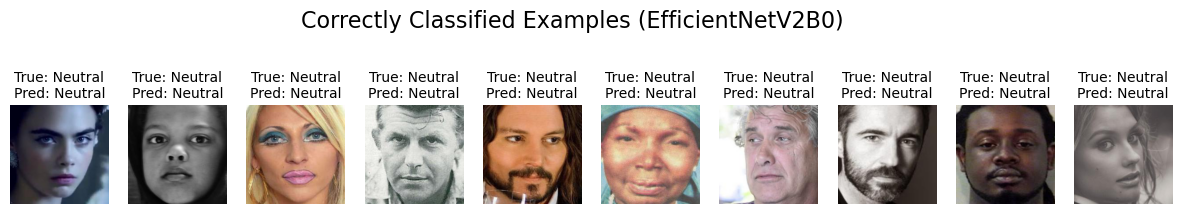

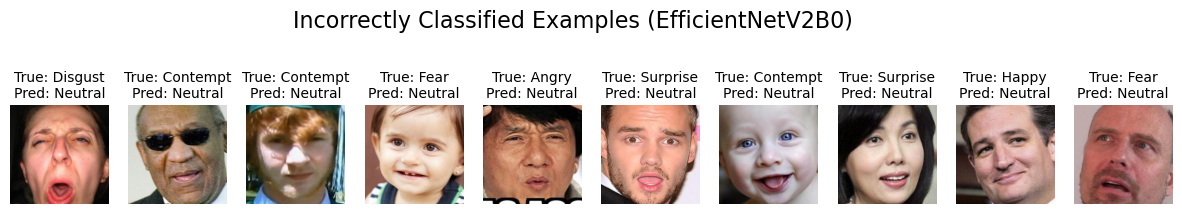

In [49]:
# Show 10 correct examples
show_examples_effnet(correct_idx_effnet, "Correctly Classified Examples (EfficientNetV2B0)", num_samples=10)

# Show 10 incorrect examples
show_examples_effnet(incorrect_idx_effnet, "Incorrectly Classified Examples (EfficientNetV2B0)", num_samples=10)

### MOBILENET MODEL

In [87]:
# --- Build MobileNet model ---
base_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_mobilenet.layers:
    layer.trainable = False  # freeze base layers

x = GlobalAveragePooling2D()(base_mobilenet.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(8, activation='softmax')(x)

model_mobilenet = Model(inputs=base_mobilenet.input, outputs=output)
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


### MOBILENET MODEL TRAINING 

In [88]:
# Define Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',        # monitor validation loss
    patience=5,                # stop if no improvement for 5 epochs
    restore_best_weights=True  # restore best model weights
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # reduce LR by 50%
    patience=3,       # if no improvement for 3 epochs, reduce LR
    min_lr=1e-6       # don't go below this LR
)

print("\n Training MobileNet...")
start_time = time.time()

# Train MobileNet with Callbacks
history_mobilenet = model_mobilenet.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=15,               
    batch_size=128,           
    callbacks=[early_stop, lr_scheduler],  # callbacks added
    verbose=1
)

mobilenet_train_time = time.time() - start_time
print(f" MobileNet Training Time: {mobilenet_train_time:.2f} seconds")



 Training MobileNet...
Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.1886 - loss: 2.1760 - val_accuracy: 0.2587 - val_loss: 1.9572 - learning_rate: 0.0010
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.2980 - loss: 1.8555 - val_accuracy: 0.2935 - val_loss: 1.8534 - learning_rate: 0.0010
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3466 - loss: 1.7356 - val_accuracy: 0.2786 - val_loss: 1.8484 - learning_rate: 0.0010
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3851 - loss: 1.6446 - val_accuracy: 0.3383 - val_loss: 1.7694 - learning_rate: 0.0010
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4369 - loss: 1.5611 - val_accuracy: 0.3184 - val_loss: 1.7673 - learning_rate: 0.0010
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4541 - loss: 1.4897 - val_accuracy: 0.3271 - val_loss: 1.7576 - learning_rate: 0.0010
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4791 - loss:

### MOBILENET MODEL EVALUATION

In [89]:
def evaluate_classification_model(y_true, y_pred, y_pred_probs, model_name):
    print(f"\nEvaluation for {model_name} MODEL")

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # F1-score (macro)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"F1-Score (Macro): {f1:.4f}")

    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Krippendorff's Alpha (requires reliability data as nominal)
    data = np.array([y_true, y_pred])
    alpha = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
    print(f"Krippendorff's Alpha: {alpha:.4f}")

    # AUC (One-vs-Rest)
    try:
        auc_ovr = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
        print(f"AUC-ROC (OvR): {auc_ovr:.4f}")
    except:
        print("Could not compute AUC-ROC (need probability outputs)")

    # Precision-Recall AUC
    try:
        auc_pr = average_precision_score(y_true, y_pred_probs, average="macro")
        print(f"Precision-Recall AUC-PR: {auc_pr:.4f}")
    except:
        print("Could not compute Precision-Recall AUC-PR (need probability outputs)")


In [90]:
y_pred_probs_mobilenet = model_mobilenet.predict(X_test)
y_pred_classes_mobilenet = np.argmax(y_pred_probs_mobilenet, axis=1)

evaluate_classification_model(y_test, y_pred_classes_mobilenet, y_pred_probs_mobilenet, "MobileNet")


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 488ms/step

Evaluation for MobileNet MODEL
Accuracy: 0.3636
F1-Score (Macro): 0.3587
Cohen's Kappa: 0.2726
Krippendorff's Alpha: 0.2710
AUC-ROC (OvR): 0.7771
Precision-Recall AUC-PR: 0.3845


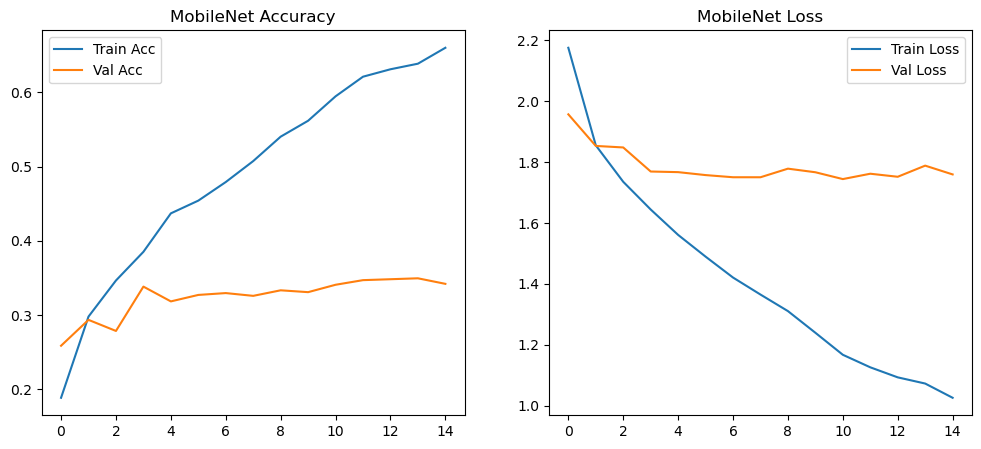

In [91]:
def plot_history(history, title):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

plot_history(history_mobilenet, "MobileNet")

In [55]:
# ✅ Get predictions for MobileNet
y_pred_probs_mobilenet = model_mobilenet.predict(X_test)
y_pred_classes_mobilenet = np.argmax(y_pred_probs_mobilenet, axis=1)

# ✅ Find indices of correct and incorrect predictions
correct_idx_mobilenet = np.where(y_pred_classes_mobilenet == y_test)[0]
incorrect_idx_mobilenet = np.where(y_pred_classes_mobilenet != y_test)[0]

print(f"📊 MobileNet Results -> Correctly classified: {len(correct_idx_mobilenet)}, Incorrectly classified: {len(incorrect_idx_mobilenet)}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step
📊 MobileNet Results -> Correctly classified: 142, Incorrectly classified: 254


In [56]:
def show_examples_mobilenet(indices, title, num_samples=10):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices[:num_samples]):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(X_test[idx])
        true_label = class_names[y_test[idx]]
        pred_label = class_names[y_pred_classes_mobilenet[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()


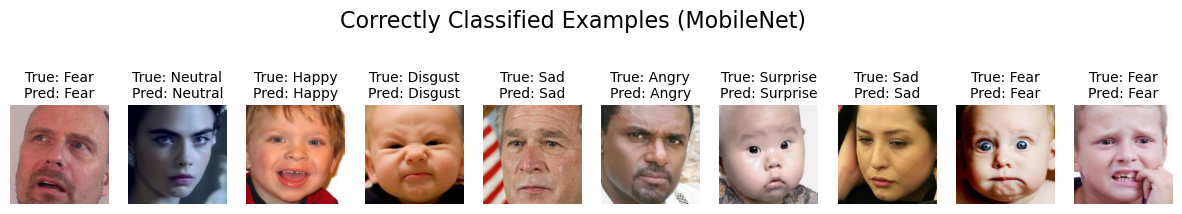

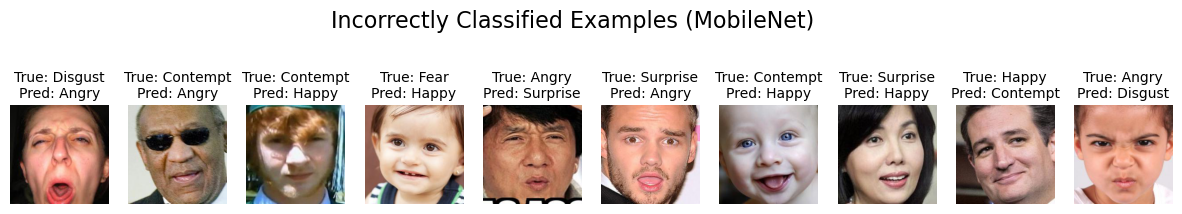

In [57]:
# Show correct predictions for MobileNet
show_examples_mobilenet(correct_idx_mobilenet, "Correctly Classified Examples (MobileNet)")

# Show incorrect predictions for MobileNet
show_examples_mobilenet(incorrect_idx_mobilenet, "Incorrectly Classified Examples (MobileNet)")


### XCEPTION MODEL

In [58]:
# --- Build Xception Model ---
base_xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_xception.layers:
    layer.trainable = False  # freeze pretrained feature extractor

x = GlobalAveragePooling2D()(base_xception.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(8, activation='softmax')(x)

model_xception = Model(inputs=base_xception.input, outputs=output)
model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# Define Callbacks (same as before)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# --------------------------
# Train Xception with Callbacks + Training Time
# --------------------------
start_time = time.time()

history_xception = model_xception.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=15,               # let early stopping decide when to stop
    batch_size=128,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time

print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 226s 10s/step - accuracy: 0.2076 - loss: 2.0250 - val_accuracy: 0.2313 - val_loss: 1.9635 - learning_rate: 0.0010
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 227s 10s/step - accuracy: 0.2912 - loss: 1.8483 - val_accuracy: 0.2525 - val_loss: 1.9107 - learning_rate: 0.0010
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 217s 10s/step - accuracy: 0.3437 - loss: 1.7581 - val_accuracy: 0.2886 - val_loss: 1.8925 - learning_rate: 0.0010
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 215s 10s/step - accuracy: 0.3658 - loss: 1.6791 - val_accuracy: 0.2836 - val_loss: 1.8867 - learning_rate: 0.0010
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 211s 10s/step - accuracy: 0.4169 - loss: 1.6067 - val_accuracy: 0.2886 - val_loss: 1.8853 - learning_rate: 0.0010
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 216s 10s/step - accuracy: 0.4523 - loss: 1.5281 - val_accuracy: 0.2998 - val_loss: 1.8817 - learning_rate: 0.0010
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 216s 10s/step - accuracy: 0.4770 - loss: 1.4771 - 

### XCEPTION MODEL EVALUATION

In [60]:
def evaluate_classification_model(y_true, y_pred, y_pred_probs, model_name):
    print(f"\nEvaluation for {model_name} MODEL")

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # F1-score (macro)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"F1-Score (Macro): {f1:.4f}")

    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Krippendorff's Alpha (requires reliability data as nominal)
    data = np.array([y_true, y_pred])
    alpha = krippendorff.alpha(reliability_data=data, level_of_measurement='nominal')
    print(f"Krippendorff's Alpha: {alpha:.4f}")

    # AUC (One-vs-Rest)
    try:
        auc_ovr = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
        print(f"AUC-ROC (OvR): {auc_ovr:.4f}")
    except:
        print("Could not compute AUC-ROC (need probability outputs)")

    # Precision-Recall AUC
    try:
        auc_pr = average_precision_score(y_true, y_pred_probs, average="macro")
        print(f"Precision-Recall AUC-PR: {auc_pr:.4f}")
    except:
        print("Could not compute Precision-Recall AUC-PR (need probability outputs)")


In [61]:
y_pred_xception = model_xception.predict(X_test)
y_pred_classes_xception = np.argmax(y_pred_xception, axis=1)

evaluate_classification_model(y_test, y_pred_classes_xception, y_pred_xception, "XCEPTION")


13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step

Evaluation for XCEPTION MODEL
Accuracy: 0.2551
F1-Score (Macro): 0.2464
Cohen's Kappa: 0.1486
Krippendorff's Alpha: 0.1472
AUC-ROC (OvR): 0.6946
Precision-Recall AUC-PR: 0.2612


### XCEPTION TRAINING GRAPHS

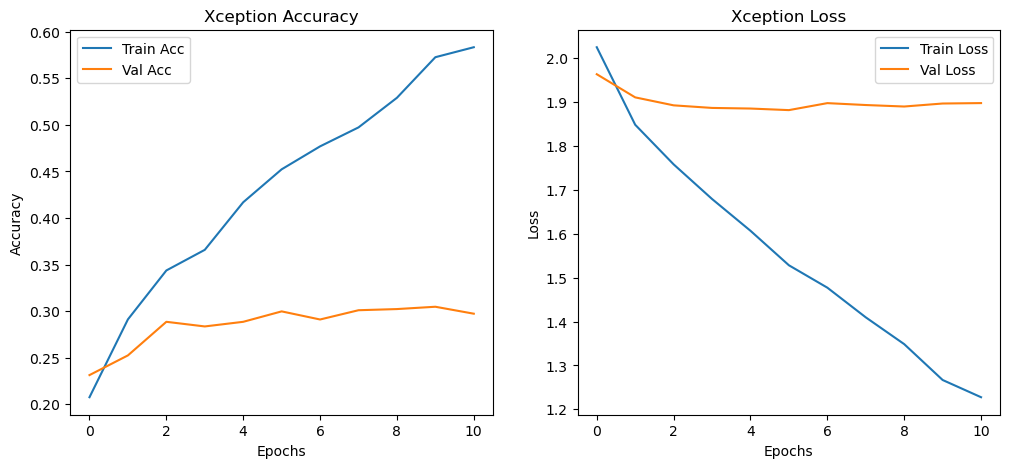

In [62]:
def plot_history(history, title):
    plt.figure(figsize=(12,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# ✅ Corrected call
plot_history(history_xception, "Xception")


### XCEPTION CORRECT AND INCORRECT IMAGE CLASSIFICATION

In [63]:
# Get predictions for Xception
y_pred_probs_xception = model_xception.predict(X_test)
y_pred_classes_xception = np.argmax(y_pred_probs_xception, axis=1)

# Find indices of correct and incorrect predictions
correct_idx_xception = np.where(y_pred_classes_xception == y_test)[0]
incorrect_idx_xception = np.where(y_pred_classes_xception != y_test)[0]

print(f"XCEPTION Correctly classified: {len(correct_idx_xception)}, Incorrectly classified: {len(incorrect_idx_xception)}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
XCEPTION Correctly classified: 101, Incorrectly classified: 295


In [64]:
def show_examples_xception(indices, title, num_samples=10):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices[:num_samples]):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(X_test[idx])
        true_label = class_names[y_test[idx]]
        pred_label = class_names[y_pred_classes_xception[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()


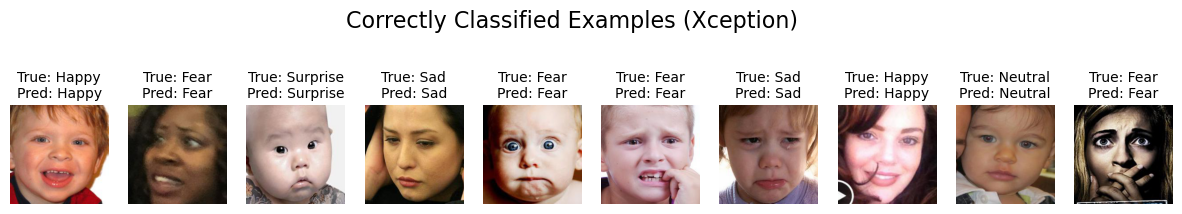

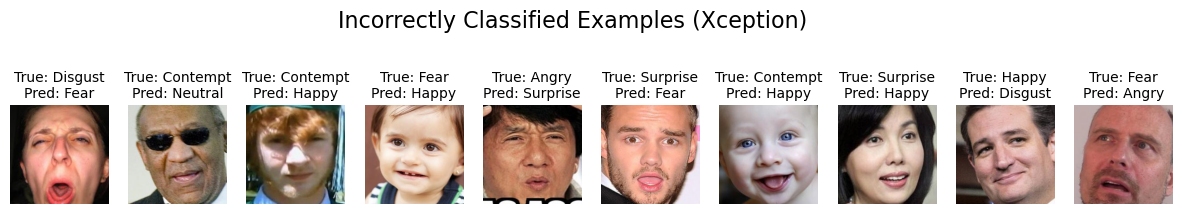

In [65]:
# Show 5 correct examples
show_examples_xception(correct_idx_xception, "Correctly Classified Examples (Xception)", num_samples=10)

# Show 5 incorrect examples
show_examples_xception(incorrect_idx_xception, "Incorrectly Classified Examples (Xception)", num_samples=10)


### VGG16-based REGRESSION

In [66]:
# Split valence/arousal using the same train/val/test indices
valence_train, valence_temp, arousal_train, arousal_temp = train_test_split(
    valence, arousal, test_size=0.3, random_state=42)

valence_val, valence_test, arousal_val, arousal_test = train_test_split(
    valence_temp, arousal_temp, test_size=0.33, random_state=42)

print(f"Valence train: {valence_train.shape}, Valence val: {valence_val.shape}, Valence test: {valence_test.shape}")


Valence train: (2799,), Valence val: (804,), Valence test: (396,)


In [67]:
base_reg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_reg.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_reg.output)
x = Dense(256, activation='relu')(x)

output_val = Dense(1, name='valence')(x)
output_aro = Dense(1, name='arousal')(x)

model_reg = Model(inputs=base_reg.input, outputs=[output_val, output_aro])

# ✅ FIX: Provide separate loss and metrics for both outputs
model_reg.compile(
    optimizer='adam',
    loss={'valence': 'mse', 'arousal': 'mse'},
    metrics={'valence': ['mae'], 'arousal': ['mae']}
)

model_reg.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_6[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 14,846,530 (56.64 MB)

 Trainable params: 131,842 (515.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [68]:
val_pred, aro_pred = model_reg.predict(X_test)

# RMSE
rmse_val = np.sqrt(mean_squared_error(valence_test, val_pred))
rmse_aro = np.sqrt(mean_squared_error(arousal_test, aro_pred))

print(f"RMSE Valence: {rmse_val:.4f}, RMSE Arousal: {rmse_aro:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step
RMSE Valence: 1.7424, RMSE Arousal: 0.3960


### Part 2: Evaluation Metrics for Continuous (Regression) Domain

In [69]:
def concordance_cc(y_true, y_pred):
    mean_true, mean_pred = np.mean(y_true), np.mean(y_pred)
    var_true, var_pred = np.var(y_true), np.var(y_pred)
    cov = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    return (2 * cov) / (var_true + var_pred + (mean_true - mean_pred) ** 2)

def sign_agreement(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred))

def evaluate_regression_model(y_true_val, y_pred_val, y_true_aro, y_pred_aro):
    print("\nContinuous Domain Evaluation")
    
    # RMSE
    rmse_val = np.sqrt(mean_squared_error(y_true_val, y_pred_val))
    rmse_aro = np.sqrt(mean_squared_error(y_true_aro, y_pred_aro))
    print(f"RMSE Valence: {rmse_val:.4f}, RMSE Arousal: {rmse_aro:.4f}")

    # Correlation
    corr_val, _ = pearsonr(y_true_val, y_pred_val.flatten())
    corr_aro, _ = pearsonr(y_true_aro, y_pred_aro.flatten())
    print(f"CORR Valence: {corr_val:.4f}, CORR Arousal: {corr_aro:.4f}")

    # SAGR
    sagr_val = sign_agreement(y_true_val, y_pred_val.flatten())
    sagr_aro = sign_agreement(y_true_aro, y_pred_aro.flatten())
    print(f"SAGR Valence: {sagr_val:.4f}, SAGR Arousal: {sagr_aro:.4f}")

    # CCC
    ccc_val = concordance_cc(y_true_val, y_pred_val.flatten())
    ccc_aro = concordance_cc(y_true_aro, y_pred_aro.flatten())
    print(f"CCC Valence: {ccc_val:.4f}, CCC Arousal: {ccc_aro:.4f}")


In [70]:
val_pred, aro_pred = model_reg.predict(X_test)
evaluate_regression_model(valence_test, val_pred, arousal_test, aro_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 62s 5s/step

Continuous Domain Evaluation
RMSE Valence: 1.7424, RMSE Arousal: 0.3960
CORR Valence: -0.0503, CORR Arousal: 0.0623
SAGR Valence: 0.2626, SAGR Arousal: 0.7576
CCC Valence: -0.0020, CCC Arousal: 0.0345
